In [ ]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.datasets import fetch_20newsgroups
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
documents = dataset.data
print('총 샘플 수 :',len(documents))

총 샘플 수 : 11314


In [ ]:
news_df = pd.DataFrame({'document':documents})
# 특수 문자 제거
news_df['clean_doc'] = news_df['document'].str.replace("[^a-zA-Z]", " ")
# 길이가 3이하인 단어는 제거 (길이가 짧은 단어 제거)
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
# 전체 단어에 대한 소문자 변환
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: x.lower())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
news_df.dropna(inplace=True)
print('총 샘플 수 :',len(news_df))

총 샘플 수 : 11314


In [ ]:
# 불용어를 제거
nltk.download("stopwords")
stop_words = stopwords.words('english')
tokenized_doc = news_df['clean_doc'].apply(lambda x: x.split())
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])
tokenized_doc = tokenized_doc.to_list()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# 단어가 1개 이하인 샘플의 인덱스를 찾아서 저장하고, 해당 샘플들은 제거.
drop_train = [index for index, sentence in enumerate(tokenized_doc) if len(sentence) <= 1]
tokenized_doc = np.delete(tokenized_doc, drop_train, axis=0)
print('총 샘플 수 :',len(tokenized_doc))

총 샘플 수 : 10940


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tokenized_doc)

word2idx = tokenizer.word_index
idx2word = {value : key for key, value in word2idx.items()}
encoded = tokenizer.texts_to_sequences(tokenized_doc)

In [ ]:
print(encoded[:2])


[[9, 59, 603, 207, 3278, 1495, 474, 702, 9470, 13686, 5533, 15227, 702, 442, 702, 70, 1148, 1095, 1036, 20294, 984, 705, 4294, 702, 217, 207, 1979, 15228, 13686, 4865, 4520, 87, 1530, 6, 52, 149, 581, 661, 4406, 4988, 4866, 1920, 755, 10668, 1102, 7837, 442, 957, 10669, 634, 51, 228, 2669, 4989, 178, 66, 222, 4521, 6066, 68, 4295], [1026, 532, 2, 60, 98, 582, 107, 800, 23, 79, 4522, 333, 7838, 864, 421, 3825, 458, 6488, 458, 2700, 4730, 333, 23, 9, 4731, 7262, 186, 310, 146, 170, 642, 1260, 107, 33568, 13, 985, 33569, 33570, 9471, 11491]]


In [ ]:
vocab_size = len(word2idx) + 1 
print('단어 집합의 크기 :', vocab_size)

단어 집합의 크기 : 64277


In [ ]:
from tensorflow.keras.preprocessing.sequence import skipgrams
# 네거티브 샘플링
skip_grams = [skipgrams(sample, vocabulary_size=vocab_size, window_size=10) for sample in encoded]

In [ ]:
# 첫번째 샘플인 skip_grams[0] 내 skipgrams로 형성된 데이터셋 확인
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(5):
    print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
          idx2word[pairs[i][0]], pairs[i][0], 
          idx2word[pairs[i][1]], pairs[i][1], 
          labels[i]))

(realize (1036), jowels (37743)) -> 0
(disagree (1495), winshield (42089)) -> 0
(story (603), unaided (30201)) -> 0
(europeans (4520), austria (4866)) -> 1
(world (70), prompts (12007)) -> 0


In [ ]:
print('전체 샘플 수 :',len(skip_grams))

전체 샘플 수 : 10940


In [ ]:
print(len(pairs))
print(len(labels))

2220
2220


In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Reshape, Activation, Input
from tensorflow.keras.layers import Dot
from tensorflow.keras.utils import plot_model
from IPython.display import SVG

In [ ]:
embedding_dim = 300

# 중심 단어를 위한 임베딩 테이블
w_inputs = Input(shape=(1, ), dtype='int32')
word_embedding = Embedding(vocab_size, embedding_dim)(w_inputs)

# 주변 단어를 위한 임베딩 테이블
c_inputs = Input(shape=(1, ), dtype='int32')
context_embedding  = Embedding(vocab_size, embedding_dim)(c_inputs)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 300)       19283100    ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 300)       19283100    ['input_2[0][0]']                
                                                                                              

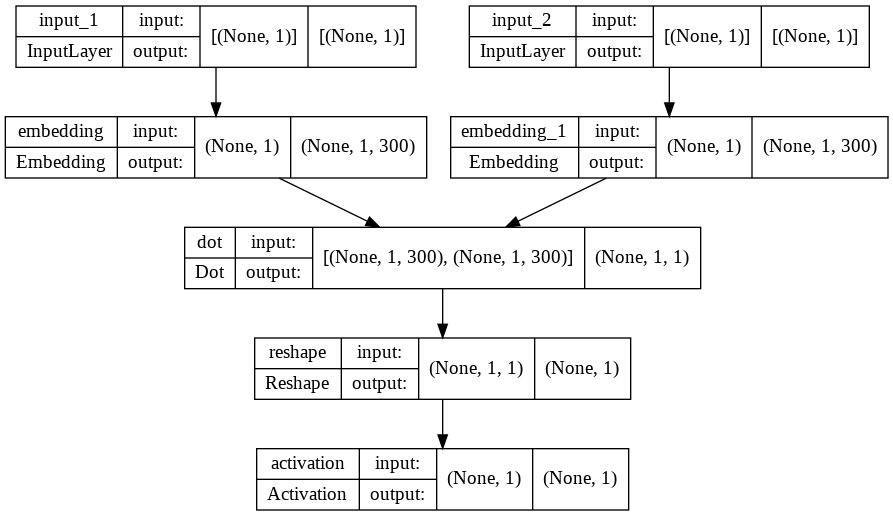

In [ ]:
dot_product = Dot(axes=2)([word_embedding, context_embedding])
dot_product = Reshape((1,), input_shape=(1, 1))(dot_product)
output = Activation('sigmoid')(dot_product)

model = Model(inputs=[w_inputs, c_inputs], outputs=output)
model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam')
plot_model(model, to_file='model3.png', show_shapes=True, show_layer_names=True, rankdir='TB')

In [ ]:
for epoch in range(1, 6):
    loss = 0
    for _, elem in enumerate(skip_grams):
        first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
        second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
        labels = np.array(elem[1], dtype='int32')
        X = [first_elem, second_elem]
        Y = labels
        loss += model.train_on_batch(X,Y)  
    print('Epoch :',epoch, 'Loss :',loss)

Epoch : 1 Loss : 4537.074023146182
Epoch : 2 Loss : 3617.477809739299
Epoch : 3 Loss : 3193.3319541357923
Epoch : 4 Loss : 2683.6491442258703
Epoch : 5 Loss : 2228.7583690679166


In [ ]:
import gensim

f = open('vectors.txt' ,'w')
f.write('{} {}\n'.format(vocab_size-1, embedding_dim))
vectors = model.get_weights()[0]
for word, i in tokenizer.word_index.items():
    f.write('{} {}\n'.format(word, ' '.join(map(str, list(vectors[i, :])))))
f.close()

# 모델 로드
w2v = gensim.models.KeyedVectors.load_word2vec_format('/content/vectors.txt', binary=False)
w2v.most_similar(positive=['soldiers'])


[('wounded', 0.5733569860458374),
 ('cruelties', 0.5600159168243408),
 ('villages', 0.5533744096755981),
 ('agdam', 0.551298201084137),
 ('shelling', 0.5499978065490723),
 ('erzurum', 0.5495625138282776),
 ('pillage', 0.5493770837783813),
 ('ottoman', 0.5469019412994385),
 ('murdered', 0.5440253019332886),
 ('azerbaijanis', 0.5416557788848877)]

In [ ]:
keys = ['soldiers', 'ignore', 'president', 'house', 'boston', 'internet', 'code', 'doctor', 'police', 'engine']

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in w2v.most_similar(word, topn=30):
        words.append(similar_word)
        embeddings.append(w2v[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you inte

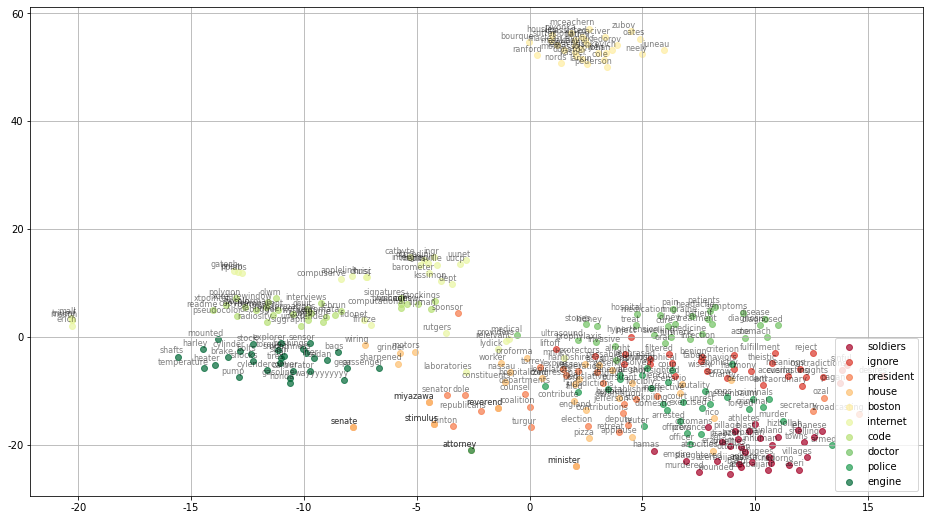

In [ ]:
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import matplotlib as mpl
% matplotlib inline

tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=4000, random_state=32)
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)


def tsne_plot_similar_words(labels, embedding_clusters, word_clusters, a=0.7):
  plt.figure(figsize=(16, 9))
  colors = cm.RdYlGn(np.linspace(0, 1, len(labels)))
  for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
    x = embeddings[:,0]
    y = embeddings[:,1]
    plt.scatter(x, y, c=color, alpha=a, label=label)
    for i, word in enumerate(words):
      plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2), 
      textcoords='offset points', ha='right', va='bottom', size=8)
  mpl.rcParams['axes.unicode_minus'] = False 
  # plt.rc('font', family='NanumBarunGothic') 
  plt.legend(loc=4)
  plt.grid(True)
  plt.show()


tsne_plot_similar_words(keys, embeddings_en_2d, word_clusters)

In [ ]:
for word in keys:
    print(word, end = ' : ')
    for similar_word, _ in w2v.most_similar(word, topn=10):
        print(similar_word, end =' ')
    print('\n\n')

soldiers : wounded cruelties villages agdam shelling erzurum pillage ottoman murdered azerbaijanis 


ignore : desires alright contradictions everlasting criterion extraordinary sorrow defendant sophistry qualms 


president : clinton turgur stimulus dole reverend attorney miyazawa republicans vessey defamation 


house : bullock senate sharpened stimulus nassau contribute miyazawa wiring pursuant scenario 


boston : sutter juneau kasper johan oates unassisted noonan mceachern pederson cole 


internet : uucp compuserve applelink kssimon huntsville uunet husc triumf dtmedin medin 


code : radiosity computational lipman polygon copyfromparent stockings cwcolormap olwm signatures cdnswc 


doctor : pain swelling medicine medication patient kidney infection migraine disease stomach 


police : officer cops arrested forged jurisdictions reuter officers behaviors province unrest 


engine : tires liter explorer bushings sedan shocks conver stock bolts mounted 


